## Set the directory of the Python scripts

In [1]:
import sys
sys.path.append("G:\\Research\\Freq-Domain\\Godzilla\\Python")

## Import all the needed packages

In [2]:
from Common import*
from Velocity import Velocity2D
from CreateGeometry import CreateGeometry2D
from CreateMatrixHelmholtz import CreateMatrixHelmholtz2D
from Tfwi import Tfwi2D
from scipy.sparse.linalg import splu
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt

## Define experiment geometry, and frequency range of all simulations

In [43]:
# Define frequency parameters (in Hertz)
freq_peak_ricker = 10
freq_max = 20
omega_max = 2 * Common.pi * freq_max
dt = 0.5 / freq_max
nt = 100
domega = (2 * Common.pi) / (nt * dt)
delay = 0.1

# Create geometry object
vmin = 1.5      # km/s
vmax = 2.5      # km/s
xdim = 0.75     # km
zdim = 0.5      # km
geom2d = CreateGeometry2D(
    xdim=xdim,
    zdim=zdim,
    vmin=vmin,
    vmax=vmax,
    omega_max=omega_max,
    omega_min=domega
)

## Create initial and final velocity models

In [4]:
# Create an initial velocity model
vel_initial = Velocity2D(geometry2d=geom2d)
ngridpoints_x = geom2d.gridpointsX
ngridpoints_z = geom2d.gridpointsZ

# Create a true velocity model (Gaussian perturbation)
vel_true = Velocity2D(geometry2d=geom2d)

# Modify vel_true
vel_true_vals = vel_true.vel
nz = int(0.5 * vel_true.geometry2D.ncellsZ + vel_true.geometry2D.ncellsZ_pad)
vel_true_vals[:,nz] = 0.25 * vmin + 0.75 * vmax
vel_true.vel = vel_true_vals

Plot the initial and final velocity models.

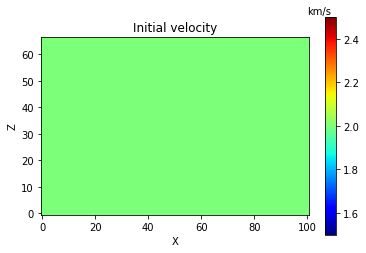

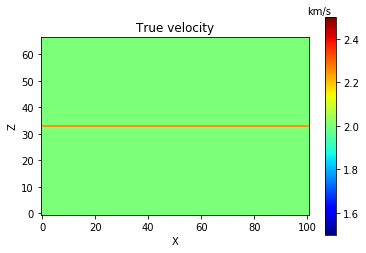

In [5]:
%matplotlib inline
# Plot models
vel_initial.plot_nopad(title="Initial velocity", vmin=vmin, vmax=vmax)
vel_true.plot_nopad(title="True velocity", vmin=vmin, vmax=vmax)

## Initialize TFWI inversion object

In [6]:
tfwi = Tfwi2D(veltrue=vel_true)
tfwi.set_starting_model(velocity=vel_initial.vel)

omega_list = np.arange(omega_max / 4, omega_max + omega_max / 4, omega_max / 4)
tfwi.set_omega_list(omega_list=omega_list)
tfwi.set_ricker_wavelet(omega_peak=2.0 * Common.pi * freq_peak_ricker)

## Perform least squares inversion

In [ ]:
tfwi.perform_lsm_cg(
    save_lsm_adjoint_image=False,
    save_lsm_adjoint_allimages=True,
    lsm_adjoint_image_file="lsm-adjoint-image-8"
)

## Display results

In [36]:
def smooth_nz(result, num_points):
    
    nx = result.shape[0]
    nz = result.shape[1]
    count = 2 * num_points + 1
    
    result1 = np.copy(result) * 0
    
    for i1 in range(nx):
        for i2 in range(nz):
            
            start = max(0, i2 - num_points)
            end = min(i2 + num_points + 1, nz)
            
            result1[i1, i2] = np.sum(result[i1, start:end]) / count
    
    return result1

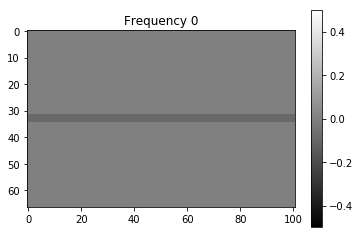

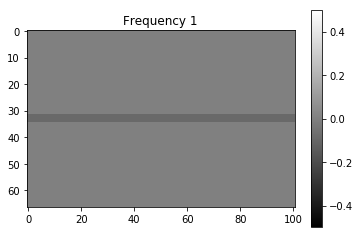

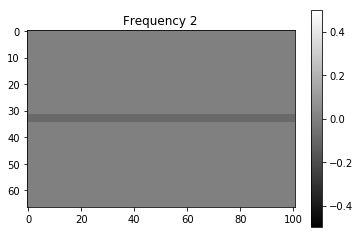

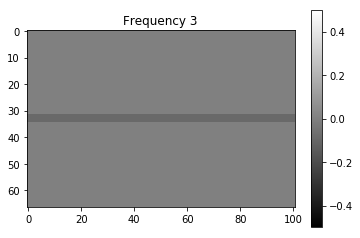

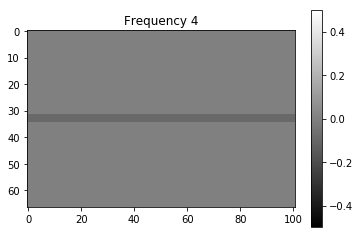

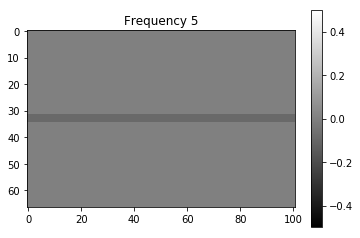

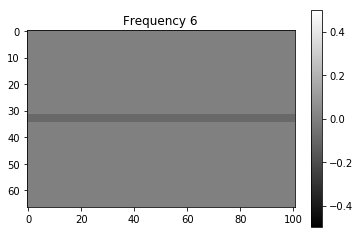

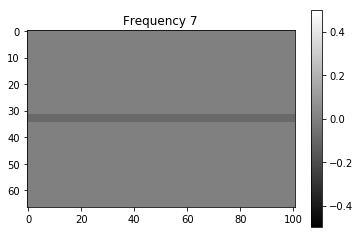

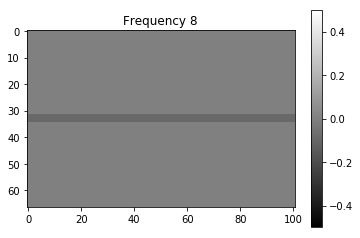

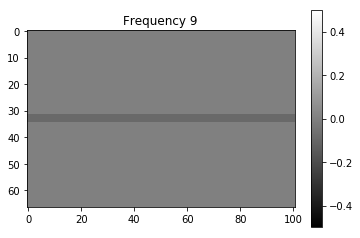

In [40]:
cells_x = vel_initial.geometry2D.ncellsX
padcells_x = vel_initial.geometry2D.ncellsX_pad
cells_z = vel_initial.geometry2D.ncellsZ
padcells_z = vel_initial.geometry2D.ncellsZ_pad

vel_diff = vel_initial.vel - vel_true.vel
vel_diff = vel_diff[padcells_x: padcells_x + cells_x + 1, padcells_z: padcells_z + cells_z + 1]
vel_diff = smooth_nz(vel_diff, num_points=1)

for i in range(10):
    plt.figure()
    plt.imshow(np.transpose(vel_diff), vmin=-0.5, vmax=0.5, cmap="gray")
    plt.title("Frequency " + str(i))
    plt.colorbar()